In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, f1_score, log_loss
from xgboost import XGBClassifier, DMatrix, train, cv

In [2]:
dados = pd.read_csv("train.csv", delimiter=',')

In [3]:
dados

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [4]:
#Verificando os tipos de dados existentes na base
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [5]:
#Verificando se ha valores missing padrao (None, NaN) na base como um todo 
dados.isnull().sum().sum()

0

In [6]:
dados_nodup = dados.drop_duplicates()
dados_nodup.shape

(76020, 371)

In [7]:
#Separa a base em 70% treino e 30% teste, estratificada pela TARGET, uma vez que ela nao tem uma proporcao equilibrada na base
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dados_nodup, test_size=0.3,stratify=dados_nodup['TARGET'],random_state=42)
train_set.shape, test_set.shape

((53214, 371), (22806, 371))

In [8]:
df = pd.DataFrame(train_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train_set.shape[0]
df

,TARGET,Percentage
0,51108,96.042395
1,2106,3.957605


In [9]:
df = pd.DataFrame(test_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/test_set.shape[0]
df

,TARGET,Percentage
0,21904,96.0449
1,902,3.9551


In [10]:
#REMOVER COLUNAS IGUAIS
features = train_set.drop(['TARGET','ID'],axis=1)
corr_matrix = features.corr()
corr_matrix.shape

(369, 369)

In [11]:
#como a matriz de correlacao se repete na diagonal superior e inferior, escolhi uma delas 
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool)) 

In [12]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] == 1)] 
print(to_drop)

['ind_var18', 'ind_var26', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var32', 'ind_var37', 'ind_var39', 'num_var18', 'num_var26', 'num_var25', 'num_var29_0', 'num_var29', 'num_var32', 'num_var37', 'num_var39', 'saldo_var29', 'delta_num_aport_var33_1y3', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3', 'delta_num_venta_var44_1y3']


In [13]:
print(len(to_drop))

25


In [14]:
features_1 = features.drop(to_drop, axis=1)
features_1.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [15]:
#REMOVER VARIAVEIS CONSTANTES, OU SEJA, COM VARIANCIA ZERO

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(features_1)  # fit encontra variaveis com variancia zero
#get_support() eh um vetor que indica quais variaveis NAO tem variancia zero
to_drop_2 = [column for column in features_1.columns if column not in features_1.columns[sel.get_support()]] 
print(to_drop_2)

['ind_var2_0', 'ind_var2', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var34_0', 'ind_var34', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var13_medio_0', 'num_var13_medio', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var34_0', 'num_var34', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var13_medio', 'saldo_var28', 'saldo_var27', 'saldo_var34', 'saldo_var41', 'saldo_var46', 'delta_imp_amort_var34_1y3', 'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_amort_var34_ult1', 'imp_reemb_var13_hace3', 'imp_reemb_var17_hace3', 'imp_reemb_var33_hace3', 'imp_reemb_var33_ult1', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_meses_var13_medio_ult3', 'num_reemb_var13_hace3', 'num_reemb_var17_hace3', 'num_reemb_var33_hace3', 'num_reemb_var33_ult1', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo

In [16]:
print(len(to_drop_2))

57


In [17]:
features_2= features_1.drop(to_drop_2, axis=1)
features_2.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [18]:
features_2.shape

(53214, 287)

In [19]:
dict = {'full': features_2.columns}
colunas = pd.DataFrame(dict)

colunas['abv'] = colunas['full'].str.slice(0,3)
colunas

,full,abv
0,var3,var
1,var15,var
2,imp_ent_var16_ult1,imp
3,imp_op_var39_comer_ult1,imp
4,imp_op_var39_comer_ult3,imp
...,...,...
282,saldo_medio_var44_hace2,sal
283,saldo_medio_var44_hace3,sal
284,saldo_medio_var44_ult1,sal
285,saldo_medio_var44_ult3,sal


In [20]:
colunas.groupby('abv').count()

,full
abv,
del,15
imp,40
ind,54
num,115
sal,58
var,5


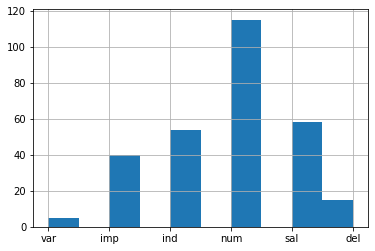

In [21]:
colunas.abv.hist()

In [22]:
colunas[colunas['abv'] == 'var']['full']

0       var3
1      var15
146    var36
193    var21
286    var38
Name: full, dtype: object

In [23]:
#TENTAR DETERMINAR SE AS VARIAVEIS SAO BINARIAS, CATEGORICAS OU CONTINUAS

#PRIMEIRO VERIFICOU-SE A QUANTIDADE DE DOMINIOS DE CADA VARIAVEL DA BASE E TENTOU-SE AGRUPAR POR QUANTIDADE DE DOMINIOS
#BINARIAS: 2 DOMINIOS
#CATEGORICAS ATE 10 DOMINIOS: DE 3 A 10 DOMINIOS OU VARS COM INICIO DO NOME DA VARIAVEL NUM (TODAS ELAS PARECEM TER
# APENAS VALORES INTEIROS ATRAVES DO DESCRIBE), REMOVENDO VARIAVEIS COM VALORES NAO INTEIROS (ELAS SE TORNAM CONTINUAS)
#CONTINUAS: FOI FEITO UM TRABALHO DE VERIFICAR QUAL ERA UMA QUANTIDADE MINIMA DE DOMINIOS NECESSARIOS PARA A VARIAVEL
# DEIXAR DE SER CATEGORICA E SE TORNAR CONTINUA, INICIOU-SE O TESTE VERIFICANDO SE A QUANTIDADE DE DOMINIOS ERA MAIOR
# QUE N/2 E FOI-SE DIMINUINDO E VERIFICANDO QUAIS VARIAVEIS ALI TINHAM NOMES PARECIDOS, ALEM DE VERIFICAR SE O DESCRIBE
# MOSTRAVA VALORES QUEBRADOS OU VALORES INTEIROS.
#  VARS COM INICIO DO NOME DA VARIAVEL SALDO, IMP OU DELTA (-1 A 1)


#VETORES DE TESTE
vars_bin = []
vars_cat10 = []
vars_cont = []

vars_bin = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) == 2]

vars_cat10 = [columns for columns in features_2.columns 
              if columns not in vars_bin
              and len(features_2[columns].value_counts()) <= 10
              or columns in colunas[colunas['abv'] == 'var']['full']]
#vars_cont = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) > 10 and len(features_2[columns].value_counts()) > int((features_2.shape[0])/500)]
vars_cont = [columns for columns in features_2.columns 
             if columns not in vars_bin 
             and columns not in vars_cat10]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10))
print('#Continuas',len(vars_cont))
#APARENTEMENTE:
#BINARIAS: com 2 categorias
#CATEGORICAS: com 3 categorias
#CONTINUAS: SALDO ou IMP ou DELTA (-1 A 1)
#CATEGORICAS: NUM ou ate 10 categorias


#Binarias 80
#Ate 10 categorias 78
#Continuas 129


In [24]:
#VERIFICA SE AS VARIAVEIS CONSIDERADAS CATEGORICAS SAO INTEIROS NAO NEGATIVOS, CASO CONTRARIO, CHAMAR DE CONTINUAS

var_cat_true = []

var_cat_true = [columns for columns in features_2[vars_cat10].columns 
                if np.array_equal(features_2[columns], features_2[columns].astype(int))
                and np.array_equal(features_2[columns], abs(features_2[columns]))]
print(len(var_cat_true))

60


In [25]:
vars_to_cont = []

vars_to_cont = [columns for columns in features_2[vars_cat10].columns if columns not in var_cat_true]
print(len(vars_to_cont))

18


In [26]:
vars_cont_2 = []
vars_cat10_2 = []

vars_cont_2 = [columns for columns in features_2.columns if columns in vars_cont or columns in vars_to_cont]
vars_cat10_2 = [columns for columns in features_2[vars_cat10].columns if columns not in vars_to_cont]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_2))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 60
#Continuas 147


In [27]:
vars_cat10_2

['num_var1_0',
 'num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14_0',
 'num_var14',
 'num_var17',
 'num_var24_0',
 'num_var24',
 'num_var26_0',
 'num_var25_0',
 'num_op_var40_hace3',
 'num_var30_0',
 'num_var30',
 'num_var31',
 'num_var32_0',
 'num_var33_0',
 'num_var33',
 'num_var39_0',
 'num_var40_0',
 'num_var41_0',
 'num_var42_0',
 'num_var42',
 'var36',
 'imp_aport_var33_ult1',
 'num_aport_var13_hace3',
 'num_aport_var13_ult1',
 'num_aport_var17_hace3',
 'num_aport_var17_ult1',
 'num_aport_var33_hace3',
 'num_aport_var33_ult1',
 'num_var7_recib_ult1',
 'num_compra_var44_hace3',
 'num_compra_var44_ult1',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var13_largo_ult3',
 'num_meses_var17_ult3',
 'num_meses_var29_ult3',
 'num_meses_var33_ult3',
 'num_meses_v

In [28]:
#FAZER UM TESTE QUI-QUADRADO ENTRE AS VARIAVEIS CAEGORICAS E A TARGET PARA VERIFICAR A ASSOCIACAO ENTRE ELAS
#Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados
# desviam dos valores observados.


# Importar metrica
from sklearn.feature_selection import chi2
# Calculando Chi-Squared
chi_scores = chi2(train_set[vars_cat10_2],train_set['TARGET'])
# Colocando label nos resultados para posterior plot
scores = pd.Series(chi_scores[0], index=vars_cat10_2)
pvalues = pd.Series(chi_scores[1], index=vars_cat10_2)

# Results
teste_chi = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})
teste_chi['associacao'] = teste_chi[teste_chi['p-Value'] <= 0.05]['p-Value']
teste_chi

,Chi2,p-Value,associacao
num_var1_0,2.056941,1.515141e-01,NaN
num_var4,245.491116,2.497193e-55,2.497193e-55
num_var5_0,7.597927,5.843544e-03,5.843544e-03
num_var5,987.652698,8.672433e-217,8.672433e-217
num_var8_0,375.266455,1.335196e-83,1.335196e-83
num_var12_0,85.862875,1.928557e-20,1.928557e-20
num_var12,156.720950,5.890152e-36,5.890152e-36
num_var13_0,240.497758,3.063180e-54,3.063180e-54
num_var13_corto_0,168.619793,1.481237e-38,1.481237e-38
num_var13_corto,171.138710,4.173166e-39,4.173166e-39


In [29]:
to_drop_3 = []
to_drop_3 = [columns for columns in teste_chi[teste_chi['p-Value'] > 0.05].index]
print(len(to_drop_3))

20


In [30]:
vars_cat10_3 = []

vars_cat10_3 = [columns for columns in features_2[vars_cat10_2].columns if columns not in to_drop_3]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_3))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 40
#Continuas 147


In [31]:
vars_cat10_3

['num_var4',
 'num_var5_0',
 'num_var5',
 'num_var8_0',
 'num_var12_0',
 'num_var12',
 'num_var13_0',
 'num_var13_corto_0',
 'num_var13_corto',
 'num_var13_largo_0',
 'num_var13_largo',
 'num_var13',
 'num_var14',
 'num_var24_0',
 'num_var24',
 'num_var26_0',
 'num_var25_0',
 'num_var30_0',
 'num_var30',
 'num_var33_0',
 'num_var39_0',
 'num_var41_0',
 'num_var42',
 'var36',
 'imp_aport_var33_ult1',
 'num_aport_var13_hace3',
 'num_aport_var13_ult1',
 'num_aport_var17_ult1',
 'num_compra_var44_ult1',
 'num_meses_var5_ult3',
 'num_meses_var8_ult3',
 'num_meses_var12_ult3',
 'num_meses_var13_corto_ult3',
 'num_meses_var13_largo_ult3',
 'num_meses_var17_ult3',
 'num_op_var40_efect_ult1',
 'num_op_var40_efect_ult3',
 'num_reemb_var17_ult1',
 'num_sal_var16_ult1',
 'num_venta_var44_ult1']

In [32]:
#FAZER UM TESTE QUI-QUADRADO ENTRE AS VARIAVEIS BINARIAS E A TARGET PARA VERIFICAR A ASSOCIACAO ENTRE ELAS
#Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados
# desviam dos valores observados.


# Importar metrica
from sklearn.feature_selection import chi2
# Calculando Chi-Squared
chi_scores = chi2(train_set[vars_bin],train_set['TARGET'])
# Colocando label nos resultados para posterior plot
scores = pd.Series(chi_scores[0], index=vars_bin)
pvalues = pd.Series(chi_scores[1], index=vars_bin)

# Results
teste_chi_bin = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})
teste_chi_bin['associacao'] = teste_chi_bin[teste_chi_bin['p-Value'] <= 0.05]['p-Value']
teste_chi_bin

,Chi2,p-Value,associacao
ind_var1_0,0.395146,5.296068e-01,NaN
ind_var1,7.387847,6.566605e-03,6.566605e-03
ind_var5_0,2.824111,9.285828e-02,NaN
ind_var5,330.017318,9.528301e-74,9.528301e-74
ind_var6_0,0.247241,6.190244e-01,NaN
...,...,...,...
num_trasp_var17_in_ult1,0.494482,4.819346e-01,NaN
num_trasp_var17_out_ult1,0.370862,5.425349e-01,NaN
num_trasp_var33_in_hace3,0.370862,5.425349e-01,NaN
num_trasp_var33_out_ult1,0.123621,7.251404e-01,NaN


In [33]:
to_drop_4 = []
to_drop_4 = [columns for columns in teste_chi_bin[teste_chi_bin['p-Value'] > 0.05].index]
print(len(to_drop_4))

35


In [34]:
vars_bin_2 = []

vars_bin_2 = [columns for columns in features_2[vars_bin].columns if columns not in to_drop_4]
print('#Binarias',len(vars_bin_2))
print('#Ate 10 categorias',len(vars_cat10_3))
print('#Continuas',len(vars_cont_2))

#Binarias 45
#Ate 10 categorias 40
#Continuas 147


In [35]:
vars_bin_2

['ind_var1',
 'ind_var5',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13_largo',
 'ind_var13',
 'ind_var14_0',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_0',
 'ind_var26_cte',
 'ind_var25_0',
 'ind_var30',
 'ind_var31_0',
 'ind_var39_0',
 'ind_var40',
 'ind_var41_0',
 'num_var1',
 'num_var8',
 'num_var20_0',
 'num_var20',
 'num_var40',
 'saldo_var18',
 'delta_imp_amort_var18_1y3',
 'delta_imp_reemb_var13_1y3',
 'delta_imp_reemb_var17_1y3',
 'delta_imp_trasp_var17_out_1y3',
 'delta_imp_trasp_var33_out_1y3',
 'imp_amort_var18_ult1',
 'imp_trasp_var33_out_ult1',
 'imp_venta_var44_hace3',
 'ind_var10_ult1',
 'ind_var10cte_ult1',
 'ind_var9_ult1',
 'ind_var43_recib_ult1']

In [36]:
features_3 = features_2.drop(to_drop_3, axis=1).drop(to_drop_4, axis=1)
features_3.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [ ]:
#VERIFICAR SE AS VARIAVEIS SAO ORDINAIS EM RELACAO A TARGET, SENAO, FAZER ENCODING OOOOU PARAR AQUI????

In [ ]:
#CRIAR VARIAVEL QUE IDENTIFICA OS CLIENTES QUE ESTAO NO RANGE DOS OUTLIERS EM TODAS AS VARIAVEIS

In [ ]:
#FEATURE SELECTION - RANDOM FOREST - GRID SEARCH

In [37]:
#Separa X e Y de treino
x_train = []
y_train = []
x_train = train_set[features_3.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 232), (53214,))

In [193]:
# #Cria var aleatoria

# x_train['random_var'] = np.random.rand(x_train.shape[0])

/Users/brunaoliveira/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
#Como os dados nao sao balanceados
#Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost
# sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty
# on misclassifying the minority class.
#class weight = balanced -> This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of
# ‘balanced‘ can be provided to automatically use the inverse weighting from the training dataset, giving focus to the
# minority class.
#class_weight='balanced_subsample' -> Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class
# distribution in the data sample will be different for each tree.
#As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample,
# instead of the entire training dataset.

rnd_clf = RandomForestClassifier(n_estimators = 10, class_weight='balanced_subsample',random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring='neg_log_loss', cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Log loss: %.3f' % (-1*(mean(scores))))
# print('Media Lucro Relativo: %.3f' % mean(scores))

Media Log loss: 0.766


In [40]:
#Faz Grid Search para ver se teriamos algum valor melhor para os hiperparametros
#Foi testado 'n_estimators': [10,30,50] E 'max_depth': range(5,50,10) E 'max_features': ['sqrt','log2'] -> best = 50, 5, sqrt
#Foi testado 'n_estimators': [30,50,100] E 'max_depth': range(5,20,10) E 'max_features': ['sqrt','log2'] -> best = 100, 5, sqrt

grid_param = {
    'n_estimators': [30,50,100],
    'criterion': ['gini'], #default
    'max_depth': range(5,20,5),
    'max_features': ['sqrt','log2'],
    'class_weight':['balanced_subsample']
}

rnd_clf = RandomForestClassifier()

grid_search = GridSearchCV(rnd_clf,grid_param,scoring='neg_log_loss',cv=10)

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [41]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [42]:
grid_search.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [43]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

-0.5476685129013728 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}
-0.54625294437333 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
-0.5466637780534187 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
-0.5765363491273566 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
-0.577057605824777 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
-0.5748982920438056 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
-0.459344016356608 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 30}
-0.45654272847017774 

In [46]:
rnd_clf = RandomForestClassifier(criterion = 'gini',
 max_depth = 15,
 max_features = 'sqrt',
 n_estimators = 100,
 class_weight = 'balanced_subsample', random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring='neg_log_loss', cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Log loss: %.3f' % (-1*mean(scores)))

Media Log loss: 0.385


In [48]:
rnd_clf.fit(x_train,y_train)

feature_scores = pd.Series(rnd_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance.csv',header=False)

feature_scores

var38                           0.208277
var15                           0.200346
saldo_medio_var5_hace3          0.059214
saldo_medio_var5_ult3           0.039496
saldo_var5                      0.026001
                                  ...   
delta_imp_reemb_var13_1y3       0.000000
delta_imp_reemb_var17_1y3       0.000000
ind_var20                       0.000000
delta_imp_trasp_var17_in_1y3    0.000000
imp_aport_var17_hace3           0.000000
Length: 232, dtype: float64

In [47]:
# feature_scores.get(key='random_var')

In [51]:
# (feature_scores <= feature_scores.get(key='random_var')).sum()
(feature_scores <= 0.01).sum()

213

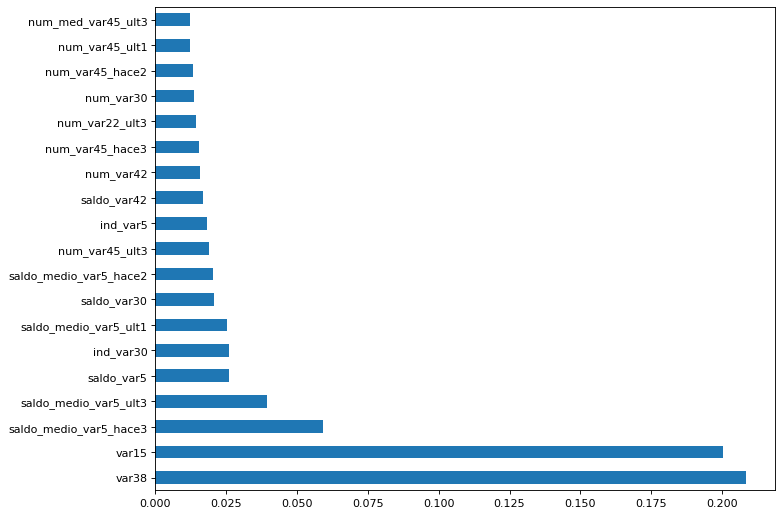

In [55]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importance = pd.Series(rnd_clf.feature_importances_, index= x_train.columns)

feat_importance.nlargest(19).plot(kind='barh')

In [53]:
to_drop_4 = []
# to_drop_4 = feature_scores.loc[lambda x: x <= feature_scores.get(key='random_var')].index[1:]
to_drop_4 = feature_scores.loc[lambda x: x <= 0.01].index

In [54]:
features_4 = features_3.drop(to_drop_4, axis=1)
features_4.head()

,var15,ind_var5,ind_var30,num_var30,num_var42,saldo_var5,saldo_var30,saldo_var42,num_var22_ult3,num_med_var45_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
61553,38,1,1,6,6,0.3,64139.49,64139.49,3,9,15,3,12,30,129.18,12.60,176.07,105.96,175887.150000
6865,51,1,1,3,3,1.5,1.50,1.50,3,0,0,3,3,6,1.50,0.72,1.50,1.23,111297.030000
847,23,1,1,3,3,3.0,3.00,3.00,0,0,0,0,0,0,3.00,0.72,3.00,2.25,117310.979016
40817,23,0,0,0,0,0.0,0.00,0.00,0,0,0,0,0,0,0.00,0.00,0.00,0.00,80805.900000
71630,23,1,1,3,3,120.0,120.00,120.00,9,3,12,0,0,12,91.98,68.28,120.00,93.42,124585.620000


In [56]:
#Separa X e Y de treino
x_train_fs = []
y_train_fs = []
x_train_fs = train_set[features_4.columns]
y_train_fs = train_set['TARGET']
x_train_fs.shape, y_train_fs.shape

((53214, 19), (53214,))

In [57]:
rnd_clf_fs = RandomForestClassifier(criterion = 'gini',
 max_depth = 15,
 max_features = 'sqrt',
 n_estimators = 100,
 class_weight = 'balanced_subsample', random_state=42)

scores_fs = cross_val_score(rnd_clf_fs, x_train_fs, y_train_fs, scoring='neg_log_loss', cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Log loss: %.3f' % (-1*mean(scores_fs)))

Media Log loss: 0.314


# Treino do Modelo

In [58]:
#Separa X e Y de treino
x_train = train_set[features_4.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 19), (53214,))

In [59]:
#Separa X e Y de treino
x_test = test_set[features_4.columns]
y_test = test_set['TARGET']
x_test.shape, y_test.shape

((22806, 19), (22806,))

#### Funcao de Lucro

In [60]:
#funcao que verifica se o lucro do modelo se aproxima do lucro max que poderia ter

def funcao_lucro(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred).ravel().tolist()
    fp = cm[1]
    tp = cm[3]

    lucro_max = sum(y_true)*90
    
    f_lucro = ((-10*fp)+(90*tp))/lucro_max

    return f_lucro

lucro = make_scorer(funcao_lucro, greater_is_better=True)

#### Lucro Maximo (100% acerto)

In [61]:
LM = sum(y_train)*90
print('Lucro Maximo: %.2f' % LM)

Lucro Maximo: 189540.00


#### Acao para todos os clientes

In [63]:
y_acao = pd.Series(np.ones(len(y_train)),name='TARGET',dtype=int)

auc = roc_auc_score(y_train, y_acao.to_list())
print('ROC AUC: %.3f' % auc)
LR = funcao_lucro(y_train,y_acao.to_list())
print('Lucro Relativo: %.3f' % LR)
print('Lucro Total: %.2f' % (LR*LM))
F1 = f1_score(y_train, y_acao.to_list())
print('F1: %.3f' % F1)
LL = log_loss(y_train,y_acao.to_list())
print('Log Loss: %.3f' % LL)

ROC AUC: 0.500
Lucro Relativo: -1.696
Lucro Total: -321540.00
F1: 0.076
Log Loss: 33.173


### XGBoost

In [ ]:
#Gerar um modelo com Gradiente Boosting
#implementacao otimizada: XGBoost - rapido, escalonavel e portatil

In [64]:
#Treinando e Testando o modelo base
XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   # max_depth = 6,
   # learning_rate = 0.01,
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

F1 = f1_score(y_train, y_p_train)
F1_test = f1_score(y_test, y_p_test)
print('F1: %.3f' % F1)
print('F1 Teste: %.3f' % F1_test)

LL = log_loss(y_train, y_p_train)
LL_test = log_loss(y_test, y_p_test)
print('Log Loss: %.3f' % LL)
print('Log Loss Teste: %.3f' % LL_test)

ROC AUC: 0.902
ROC AUC Teste: 0.725
Lucro Relativo: 0.573
Lucro Relativo Teste: 0.199
Lucro Total: 108580.00
Lucro Total Teste: 37660.51
F1: 0.359
F1 Teste: 0.230
Log Loss: 4.595
Log Loss Teste: 5.442


In [65]:
XGB.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 24.267806267806268,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [ ]:
#Tuna hiperparametros
#Faz grid search para selecionar os melhores hiperparametros
#Feature selection
#grafico de aumento de vars por aumento de lucro (menor complexidade vs maior lucro)

In [66]:
#Faz Random Search para ver se teriamos algum valor melhor para os hiperparametros
#Random Search eh melhor para tunar hiperparametros com XGBoost, pois ele considera algumas combinacoes aleatorias de parametros e nao
# todas (como o Grid Search). Logo, como o XGBoost faz modelos sequenciais e, consequentemente, demora mais, melhor usar o Random. 
#https://xgboost.readthedocs.io/en/stable/parameter.html

#Fiz 'learning_rate': np.arange(0.1,1.01,0.2) -> 0.1

XGB_grid_param = {
    'n_estimators': range(10,100,10),
    'max_depth': range(3,13,3), #default 6
    'learning_rate': [0.001,0.01,0.1], #default 0,3
    'subsample': np.arange(0.25,1.01,0.25), #default 1
    'colsample_bytree': np.arange(0.25,1.01,0.25), #default 1
}

In [67]:
random_search = RandomizedSearchCV(estimator=XGB, 
                           param_distributions=XGB_grid_param,
                           n_iter=100,
                           scoring='neg_log_loss', 
                           n_jobs=-1, 
                           cv=5)

random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learni...
                                           reg_alpha=0, ...),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array

In [68]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [69]:
random_search.best_params_

{'subsample': 0.75,
 'n_estimators': 90,
 'max_depth': 12,
 'learning_rate': 0.1,
 'colsample_bytree': 1.0}

In [70]:
random_search.cv_results_

{'mean_fit_time': array([13.26843262, 16.56655569, 11.23140769, 13.93937078,  0.86766777,
         4.82858782,  7.38948741, 26.42498651,  5.17203002,  2.12703519,
        23.87137809,  4.5381937 ,  3.6719871 , 35.28679214,  4.15948281,
         6.03553143,  9.06929893,  1.49227996,  1.08233232,  3.62501965,
        11.50649238, 13.74818687, 15.5018384 ,  3.03446331,  2.75120773,
         7.68100252,  5.81132374, 18.30661983,  5.76865468,  4.17913952,
         7.05362406, 11.45099115, 17.25128303,  9.97796879,  2.60304041,
        25.39945927,  6.94355803, 21.2623157 ,  1.62424879,  1.29423862,
        11.69851151, 12.54156523, 12.68813357,  6.59157839,  8.04002433,
        17.5529026 , 11.11711664, 16.4340044 ,  1.74054246,  1.88750854,
         3.85013213,  2.56141639,  2.4258554 ,  1.29341602,  7.24677615,
         8.28088188, 10.92665281,  1.69201951, 31.90888286, 10.35121136,
         6.86919098,  4.13315721, 10.63396497,  9.76805043,  6.10980496,
        11.85153356,  0.86322694, 

In [71]:

XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   n_estimators = 90, #30 40 60 40
   max_depth = 12, #6 9 12 12
   learning_rate = 0.1, #0.01 0.1 0.01 0.001
   colsample_bytree = 1,
   subsample = 0.75, #0.25 0.25 0.25 0.5
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

F1 = f1_score(y_train, y_p_train)
F1_test = f1_score(y_test, y_p_test)
print('F1: %.3f' % F1)
print('F1 Teste: %.3f' % F1_test)

LL = log_loss(y_train, y_p_train)
LL_test = log_loss(y_test, y_p_test)
print('Log Loss: %.3f' % LL)
print('Log Loss Teste: %.3f' % LL_test)

ROC AUC: 0.952
ROC AUC Teste: 0.691
Lucro Relativo: 0.762
Lucro Relativo Teste: 0.215
Lucro Total: 144460.00
Lucro Total Teste: 40765.81
F1: 0.491
F1 Teste: 0.249
Log Loss: 2.796
Log Loss Teste: 3.956


In [138]:
scores = cross_val_score(XGB, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.239


In [ ]:
ROC AUC: 0.768
ROC AUC Teste: 0.759
Lucro Relativo: 0.208
Lucro Relativo Teste: 0.180
Lucro Total: 39400.00
Lucro Total Teste: 34181.64
F1: 0.227
F1 Teste: 0.219

In [ ]:
XGB.fit(x_train,y_train)

feature_scores = pd.Series(XGB.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance_XGB.csv',header=False)

feature_scores

var15                       0.121741
saldo_var30                 0.076560
saldo_var42                 0.062785
saldo_var5                  0.050800
saldo_medio_var5_ult1       0.049382
                              ...   
ind_var7_emit_ult1          0.000000
num_var17_0                 0.000000
num_var18_0                 0.000000
num_var20                   0.000000
imp_trasp_var17_in_hace3    0.000000
Length: 268, dtype: float64

In [ ]:
XGB_grid_param = {
    'n_estimators': range(10,100,10),
    'max_depth': range(3,13,3), #default 6
    'learning_rate': [0.001,0.01,0.1], #default 0,3
    'subsample': np.arange(0.25,1.01,0.25), #default 1
}

In [86]:
n_col = [5,10,15,20,30,40,50,70,100]
n_col.

AttributeError: 'list' object has no attribute 'dtype'

In [81]:
a = []
a = np.array(['x','y'])

b = np.append(a,['z'])
a = a.append(random_search.best_params_['subsample'])
a = a.append(random_search.best_params_['learning_rate'])
a

AttributeError: 'NoneType' object has no attribute 'append'

In [ ]:
n_col = [5,10,15,20,30,40,50,70,100]
n_est = []
max_dp = []
l_rate = []
subsp = []
i = 0

for n in n_col:
    
    x_train_sample = x_train[x_train.columns[:n]]

    random_search = RandomizedSearchCV(estimator=XGB, 
                            param_distributions=XGB_grid_param,
                            n_iter=100,
                            scoring=lucro, 
                            n_jobs=-1, 
                            cv=5)

    random_search.fit(x_train_sample,y_train)

    n_est[i] = random_search.best_params_['subsample']

In [ ]:
random_search.best_params_

{'subsample': 0.25,
 'n_estimators': 60,
 'max_depth': 12,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

In [78]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

0.03773925423120555 {'subsample': 0.75, 'n_estimators': 70, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.25}
0.24109661702541016 {'subsample': 0.5, 'n_estimators': 40, 'max_depth': 12, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
0.173361437853375 {'subsample': 0.25, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
-0.02893338471668587 {'subsample': 0.75, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.25}
0.21028042287561385 {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.75}
0.07666069800855917 {'subsample': 0.5, 'n_estimators': 20, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
0.21545424530977197 {'subsample': 0.5, 'n_estimators': 80, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
0.128028590288347 {'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
0.21260243845

In [ ]:
random_search.cv_results_

{'mean_fit_time': array([ 4.33855481,  7.01745782, 11.43931851,  1.36729298,  1.98947186,
         9.68526158,  1.61715202, 19.5656261 ,  6.30104685, 11.9486001 ,
         2.64885592,  7.96334801,  6.3558681 ,  4.22727823,  4.46220798,
         0.76929431,  0.64557896,  1.70019608,  3.19084687,  3.55785933,
         3.45822229,  3.70062704,  1.25550461,  0.80436006,  2.35637555,
         2.59620304,  0.87908049,  3.96140661, 14.38854384,  0.65423627,
        16.18291926,  3.83336215,  6.69907036, 13.36901145,  5.63899488,
         0.92601681,  0.50508542,  6.67481055,  7.5546946 ,  4.96213465,
         1.87533169,  3.35573759,  1.8562788 ,  4.322118  ,  0.69895673,
         4.57275319,  7.98207598,  1.0717247 ,  5.12769585,  1.96209564,
        12.77641258,  2.48255925, 11.10846157,  9.1010705 , 13.47545323,
         8.0668541 , 12.49923882,  4.74128838, 12.70325933,  1.77395134,
        19.57843223,  1.63026342,  0.88979816,  8.50941133,  1.7502008 ,
        18.79781518,  4.16441989, 

In [ ]:

XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   n_estimators = 10,
   max_depth = 12,
   learning_rate = 0.01,
   subsample = 0.25,
   colsample_bytree = 1,
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % (-1*LR))
print('Lucro Relativo Teste: %.3f' % (-1*LR_test))
print('Lucro Total: %.2f' % ((-1*LR)*LM))
print('Lucro Total Teste: %.2f' % ((-1*LR_test)*LM))

F1 = f1_score(y_train, y_p_train)
F1_test = f1_score(y_test, y_p_test)
print('F1: %.3f' % F1)
print('F1 Teste: %.3f' % F1_test)

ROC AUC: 0.760
ROC AUC Teste: 0.715
Lucro Relativo: -0.337
Lucro Relativo Teste: -0.243
Lucro Total: -63960.00
Lucro Total Teste: -45972.44
F1: 0.296
F1 Teste: 0.256


In [ ]:
#FEATURE SELECTION - RANDOM FOREST - GRID SEARCH

In [158]:
#Separa X e Y de treino
x_train = []
y_train = []
x_train = train_set[features_3.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 232), (53214,))

In [159]:
#funcao que verifica se o lucro do modelo se aproxima do lucro max que poderia ter

def funcao_lucro(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred).ravel().tolist()
    fp = cm[1]
    tp = cm[3]

    lucro_max = sum(y_true)*90
    
    f_lucro = ((-10*fp)+(90*tp))/lucro_max

    return f_lucro

lucro = make_scorer(funcao_lucro, greater_is_better=True)

In [160]:
#Como os dados nao sao balanceados
#Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost
# sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty
# on misclassifying the minority class.
#class weight = balanced -> This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of
# ‘balanced‘ can be provided to automatically use the inverse weighting from the training dataset, giving focus to the
# minority class.
#class_weight='balanced_subsample' -> Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class
# distribution in the data sample will be different for each tree.
#As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample,
# instead of the entire training dataset.

rnd_clf = RandomForestClassifier(n_estimators = 10, class_weight='balanced_subsample',random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.042


In [161]:
#Faz Grid Search para ver se teriamos algum valor melhor para os hiperparametros
#Foi testado 'n_estimators': [10,30,50] E 'max_depth': range(5,50,10) E 'max_features': ['sqrt','log2'] -> best = 50, 5, sqrt
#Foi testado 'n_estimators': [30,50,100] E 'max_depth': range(5,20,10) E 'max_features': ['sqrt','log2'] -> best = 100, 5, sqrt

grid_param = {
    'n_estimators': [30,50,100],
    'criterion': ['gini'], #default
    'max_depth': range(5,20,5),
    'max_features': ['sqrt','log2'],
    'class_weight':['balanced_subsample']
}

rnd_clf = RandomForestClassifier()

grid_search = GridSearchCV(rnd_clf,grid_param,scoring=lucro,cv=10)

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [162]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [163]:
grid_search.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [164]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

-0.0650460954889537 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}
-0.06884840261326725 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
-0.0652041453283581 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
-0.0821851848638086 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
-0.08082422667351766 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
-0.08197727486340735 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.08388962934144628 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 30}
0.058768539056

In [165]:
rnd_clf = RandomForestClassifier(criterion = 'gini',
 max_depth = 15,
 max_features = 'sqrt',
 n_estimators = 100,
 class_weight = 'balanced_subsample', random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.184


In [166]:
rnd_clf.fit(x_train,y_train)

feature_scores = pd.Series(rnd_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance.csv',header=False)

feature_scores

var15                        0.168336
saldo_var30                  0.044406
var38                        0.044155
saldo_medio_var5_hace2       0.040667
saldo_medio_var5_hace3       0.038507
                               ...   
delta_imp_amort_var18_1y3    0.000000
imp_amort_var18_ult1         0.000000
imp_var7_emit_ult1           0.000000
imp_aport_var33_ult1         0.000000
delta_num_aport_var17_1y3    0.000000
Length: 232, dtype: float64

In [167]:
(feature_scores <= 0).sum()

21

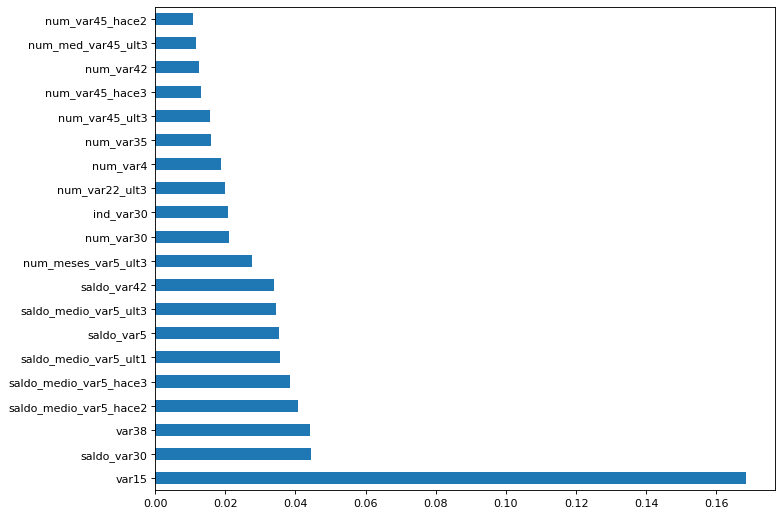

In [168]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importance = pd.Series(rnd_clf.feature_importances_, index= x_train.columns)

feat_importance.nlargest(20).plot(kind='barh')

In [169]:
to_drop_4 = []
to_drop_4 = feature_scores.loc[lambda x: x <= 0].index[1:]

In [170]:
features_4 = features_3.drop(to_drop_4, axis=1)
features_4.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


# Treino do Modelo

In [171]:
#Separa X e Y de treino
x_train = train_set[features_4.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 212), (53214,))

In [172]:
#Separa X e Y de treino
x_test = test_set[features_4.columns]
y_test = test_set['TARGET']
x_test.shape, y_test.shape

((22806, 212), (22806,))

#### Define Funcao de Lucro para Maximizar

In [173]:
#funcao que verifica se o lucro do modelo se aproxima do lucro max que poderia ter

def funcao_lucro(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred).ravel().tolist()
    fp = cm[1]
    tp = cm[3]

    lucro_max = sum(y_true)*90
    
    f_lucro = ((-10*fp)+(90*tp))/lucro_max

    return f_lucro

lucro = make_scorer(funcao_lucro, greater_is_better=True)

#### Lucro Maximo (100% acerto)

In [174]:
LM = sum(y_train)*90
print('Lucro Maximo: %.2f' % LM)

Lucro Maximo: 189540.00


#### Acao para todos os clientes

In [175]:
y_acao = pd.Series(np.ones(len(y_train)),name='TARGET',dtype=int)

auc = roc_auc_score(y_train, y_acao.to_list())
print('ROC AUC: %.3f' % auc)
LR = funcao_lucro(y_train,y_acao.to_list())
print('Lucro Relativo: %.3f' % LR)
print('Lucro Total: %.2f' % (LR*LM))
F1 = f1_score(y_train, y_acao.to_list())
print('F1: %.3f' % F1)

ROC AUC: 0.500
Lucro Relativo: -1.696
Lucro Total: -321540.00
F1: 0.076


### XGBoost

In [176]:
#Treinando e Testando o modelo base
XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   # max_depth = 6,
   # learning_rate = 0.3,
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

F1 = f1_score(y_train, y_p_train)
F1_test = f1_score(y_test, y_p_test)
print('F1: %.3f' % F1)
print('F1 Teste: %.3f' % F1_test)

ROC AUC: 0.890
ROC AUC Teste: 0.733
Lucro Relativo: 0.542
Lucro Relativo Teste: 0.208
Lucro Total: 102710.00
Lucro Total Teste: 39364.92
F1: 0.345
F1 Teste: 0.233


In [ ]:
#Tuna hiperparametros
#Faz grid search para selecionar os melhores hiperparametros
#Feature selection
#grafico de aumento de vars por aumento de lucro (menor complexidade vs maior lucro)

In [177]:
#Faz Random Search para ver se teriamos algum valor melhor para os hiperparametros
#Random Search eh melhor para tunar hiperparametros com XGBoost, pois ele considera algumas combinacoes aleatorias de parametros e nao
# todas (como o Grid Search). Logo, como o XGBoost faz modelos sequenciais e, consequentemente, demora mais, melhor usar o Random. 
#https://xgboost.readthedocs.io/en/stable/parameter.html

#Fiz 'learning_rate': np.arange(0.1,1.01,0.2) -> 0.1

XGB_grid_param = {
    'n_estimators': range(10,100,10),
    'max_depth': range(3,13,3), #default 6
    'learning_rate': [0.01,0.1,0.3], #default 0,3
    'subsample': np.arange(0.25,1.01,0.25), #default 1
    'colsample_bytree': np.arange(0.25,1.01,0.25), #default 1
}

In [178]:
random_search = RandomizedSearchCV(estimator=XGB, 
                           param_distributions=XGB_grid_param,
                           n_iter=100,
                           scoring=lucro, 
                           n_jobs=-1, 
                           cv=5)

random_search.fit(x_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learni...
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.25, 0.5 , 0.75, 1.  ]),
                                  

In [179]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=20, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [180]:
random_search.best_params_

{'subsample': 0.25,
 'n_estimators': 20,
 'max_depth': 12,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

In [185]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

0.21687569626742753 {'subsample': 0.75, 'n_estimators': 80, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
0.21967869822205585 {'subsample': 0.75, 'n_estimators': 80, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
0.13358557768037752 {'subsample': 0.5, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.75}
0.12173175633640014 {'subsample': 0.5, 'n_estimators': 10, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.25}
0.11674562630172344 {'subsample': 1.0, 'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.001, 'colsample_bytree': 1.0}
0.17118815704121002 {'subsample': 0.5, 'n_estimators': 80, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.5}
0.1978323502463499 {'subsample': 1.0, 'n_estimators': 30, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.25}
0.21054641021833587 {'subsample': 1.0, 'n_estimators': 30, 'max_depth': 12, 'learning_rate': 0.3, 'colsample_bytree': 0.75}
0.1728792247

In [182]:

XGB = XGBClassifier(
   scale_pos_weight = sum(y_train == 0) / sum(y_train == 1),
   n_estimators = 20, #30 40 60
   max_depth = 12, #6 9 12
   learning_rate = 0.01, #0.01 0.1 0.01
   colsample_bytree = 1,
   subsample = 0.25,
   random_state = 42
)
XGB.fit(x_train,y_train)
y_p_train = XGB.predict(x_train)
y_p_test = XGB.predict(x_test)

auc = roc_auc_score(y_train, y_p_train)
auc_test = roc_auc_score(y_test, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train, y_p_train)
LR_test = funcao_lucro(y_test, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

F1 = f1_score(y_train, y_p_train)
F1_test = f1_score(y_test, y_p_test)
print('F1: %.3f' % F1)
print('F1 Teste: %.3f' % F1_test)

ROC AUC: 0.761
ROC AUC Teste: 0.715
Lucro Relativo: 0.346
Lucro Relativo Teste: 0.253
Lucro Total: 65620.00
Lucro Total Teste: 47863.64
F1: 0.303
F1 Teste: 0.262


In [183]:
scores = cross_val_score(XGB, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.240


In [ ]:
ROC AUC: 0.768
ROC AUC Teste: 0.759
Lucro Relativo: 0.208
Lucro Relativo Teste: 0.180
Lucro Total: 39400.00
Lucro Total Teste: 34181.64
F1: 0.227
F1 Teste: 0.219

In [186]:
XGB.fit(x_train,y_train)

feature_scores = pd.Series(XGB.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance_XGB.csv',header=False)

feature_scores

saldo_var30                0.084554
var15                      0.030287
imp_op_var39_ult1          0.020765
num_sal_var16_ult1         0.020743
num_op_var41_comer_ult1    0.020204
                             ...   
saldo_var20                0.000000
saldo_var24                0.000000
num_op_var40_efect_ult1    0.000000
num_op_var40_comer_ult3    0.000000
saldo_var31                0.000000
Length: 212, dtype: float32

In [187]:
(feature_scores <= 0).sum()

110

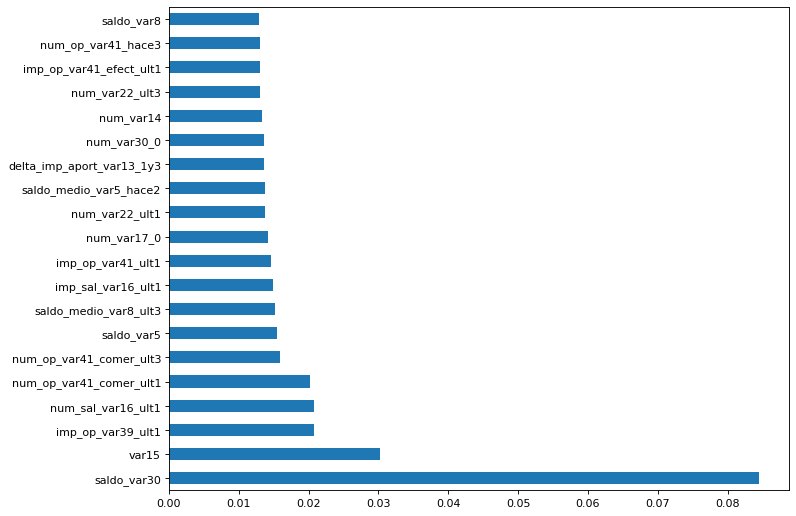

In [190]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importance = pd.Series(XGB.feature_importances_, index= x_train.columns)

feat_importance.nlargest(20).plot(kind='barh')